In [17]:
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')
set_matplotlib_formats('png')

%load_ext autoreload
%autoreload 2
import util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Decoding analyses

We first aggregate and plot mean-average-rank statistics for each decoder.

In [18]:
models = {
#     "GloVe": "baseline",
#     "ConvS2S": "fairseq.wmt14.en-fr.fconv",
#     "InferSent": "infersent.allnli",
#     "IMDB": "imdbsentiment",
#     "skipthought": "skipthought",
#     "DisSent": "dissent.books8.epoch9",
#     "order": "order-embeddings",
#     "ELMo": "elmo.2x4096",
#     "BERT": "bert.base",
# #     "BERT Large": "bert.base-large",
#     "BERT-MRPC": "bert.base.finetune-MRPC",
#     "BERT-CoLA": "bert.base.finetune-CoLA",
#     "BERT-MNLI": "bert.base.finetune-MNLI",
#     "BERT-RTE": "bert.base.finetune-RTE",
#     "BERT-SST": "bert.base.finetune-SST",
#     "BERT-WNLI": "bert.base.finetune-WNLI",
#     "BERT-QQP": "bert.base.finetune-QQP",
#     "BERT-SNLI": "bert.base.finetune-SNLI",
#     "openai": "transformer.roc",
    
    # Full eval
#     "BERT": "bert.base",
# #     "BERT Large": "bert.base-large",
#     "BERT-MRPC": "bert.base.finetune-5000-MRPC",
#     "BERT-CoLA": "bert.base.finetune-5000-CoLA",
#     "BERT-MNLI": "bert.base.finetune-5000-MNLI",
#     "BERT-RTE": "bert.base.finetune-5000-RTE",
#     "BERT-SST": "bert.base.finetune-5000-SST",
#     "BERT-WNLI": "bert.base.finetune-5000-WNLI",
#     "BERT-QQP": "bert.base.finetune-5000-QQP",
#     "BERT-SNLI": "bert.base.finetune-5000-SNLI",
#     "BERT-SQuAD": "bert.base.finetune-5000-SQuAD",
    
    "BERT": "bert.base",
    "BERT-MNLI": "bert.base.finetune-5000-MNLI",
    "BERT-SST": "bert.base.finetune-5000-SST",
    "BERT-QQP": "bert.base.finetune-5000-QQP",
    "BERT-SQuAD": "bert.base.finetune-5000-SQuAD",
    #"GPT": "gpt2"
}

In [19]:
stats = {}

--------

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


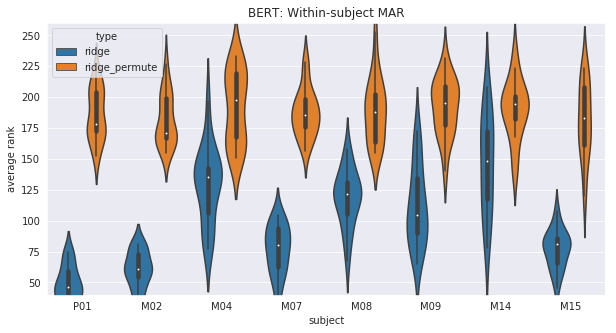

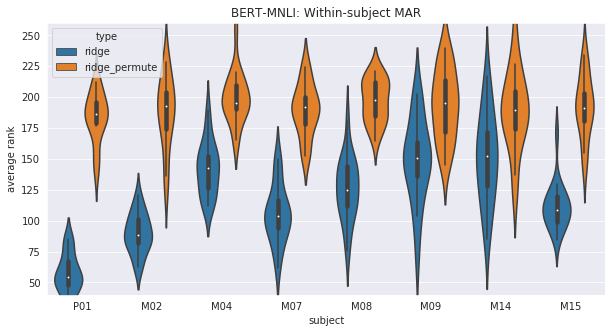

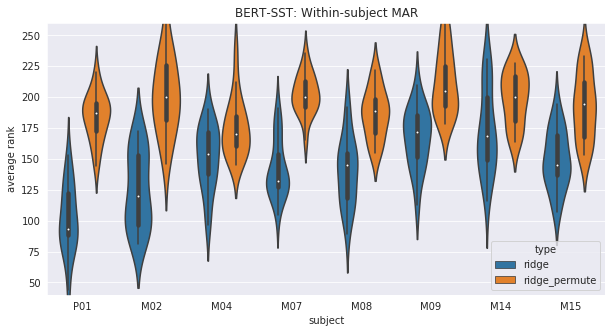

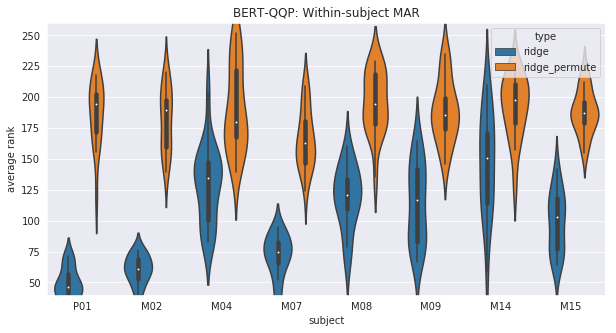

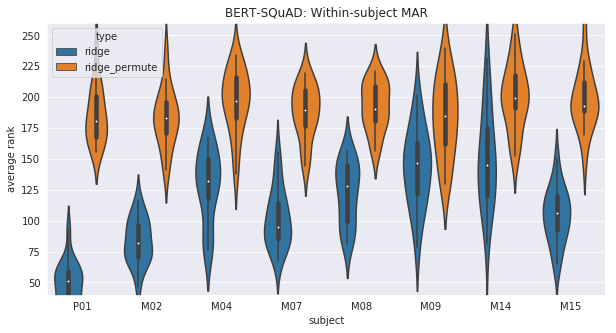

In [20]:
for model, path in models.items():
    f, ax = plt.subplots(figsize=(10,5))
    try:
        stats[model] = util.load_decoding_perf(model, "perf.384sentences.%s.csv" % path, ax=ax)
    except: raise

-----

# Pairwise statistical tests

We'll calculate which model pair differences in performance are significant by the Wilcoxon test on the original sentence-rank data. (The data graphed above are all computed from MAR statistics (meaned across sentences).)

In [21]:
# Aggregate statistics.
f = pd.concat(stats, names=["target", "metric", "stat"]).reset_index()

In [22]:
f.head()

,target,metric,stat,P01,M02,M04,M07,M08,M09,M14,M15
0,BERT,ridge,mean,48.703704,61.005291,129.359788,76.989418,118.492063,111.478836,146.555556,77.224868
1,BERT,ridge,sem,3.512983,3.432833,7.226109,4.575689,5.369849,7.498580,9.325991,3.653820
2,BERT,ridge_permute,mean,185.690476,181.613757,191.584656,187.447090,189.187831,192.084656,190.251323,181.079365
3,BERT,ridge_permute,sem,4.823489,4.902117,6.917099,4.524329,6.201333,5.375544,5.617909,7.024542
4,BERT-MNLI,ridge,mean,57.653439,89.994709,142.195767,105.584656,125.915344,149.121693,151.087302,111.719577


In [23]:
f = pd.melt(f, id_vars=["target", "metric", "stat"],
            var_name="subject", value_name="value")
f.head()

,target,metric,stat,subject,value
0,BERT,ridge,mean,P01,48.703704
1,BERT,ridge,sem,P01,3.512983
2,BERT,ridge_permute,mean,P01,185.690476
3,BERT,ridge_permute,sem,P01,4.823489
4,BERT-MNLI,ridge,mean,P01,57.653439


In [24]:
wilcoxon_results = util.wilcoxon_rank_preds(models)
wilcoxon_results.head()

0.000125 80


w_stat         p_val  p_val_corrected
model1 model2    subject                                        
BERT   BERT-MNLI M02      18193.0  3.002504e-15     2.402003e-13
                 M04      28736.5  3.216968e-03     2.573574e-01
                 M07      18878.0  2.564977e-14     2.051982e-12
                 M08      30358.0  4.492765e-02     3.594212e+00
                 M09      18508.0  3.884595e-16     3.107676e-14

In [25]:
wilcoxon_results["significant_bonferroni"] = wilcoxon_results["p_val_corrected"] < 0.01
wilcoxon_results.sort_values("p_val")

w_stat         p_val  p_val_corrected  \
model1    model2     subject                                           
BERT      BERT-SST   M15      10801.5  9.499970e-32     7.599976e-30   
BERT-SST  BERT-QQP   M07      11401.5  7.099695e-30     5.679756e-28   
                     M02      11085.5  1.556257e-29     1.245006e-27   
BERT      BERT-SST   M02      11302.0  3.090636e-29     2.472509e-27   
                     M07      12754.0  1.512966e-26     1.210373e-24   
BERT-SST  BERT-QQP   P01      15340.0  8.035285e-20     6.428228e-18   
BERT      BERT-SST   P01      15613.0  1.028770e-19     8.230156e-18   
                     M09      16224.5  1.332741e-19     1.066193e-17   
BERT-SST  BERT-SQuAD P01      15688.0  3.816734e-19     3.053387e-17   
BERT      BERT-MNLI  M15      16180.0  4.726050e-19     3.780840e-17   
BERT-MNLI BERT-QQP   M07      16260.5  6.693643e-19     5.354914e-17   
BERT-SST  BERT-QQP   M09      16921.0  1.004259e-18     8.034071e-17   
BERT-MNLI BERT-QQP   M02      16995.0  3.940847e-17     3.152678e-15   
BERT-SST  BERT-QQP   M15      17498.5  1.199743e-16     9.597943e-15   
BERT-QQP  BERT-SQuAD M02      17786.5  1.479642e-16     1.183714e-14   
BERT      BERT-MNLI  M09      18508.0  3.884595e-16     3.107676e-14   
BERT-QQP  BERT-SQuAD M07      18229.5  1.363490e-15     1.090792e-13   
BERT      BERT-QQP   M15      18063.5  1.811984e-15     1.449587e-13   
          BERT-SQuAD M09      18416.0  2.807001e-15     2.245601e-13   
          BERT-MNLI  M02      18193.0  3.002504e-15     2.402003e-13   
BERT-MNLI BERT-SST   P01      18617.0  3.814269e-15     3.051415e-13   
          BERT-QQP   M09      18504.5  3.945846e-15     3.156677e-13   
BERT      BERT-MNLI  M07      18878.0  2.564977e-14     2.051982e-12   
BERT-SST  BERT-SQuAD M02      18818.0  5.115509e-14     4.092407e-12   
BERT      BERT-SQuAD M02      19199.0  2.071002e-13     1.656801e-11   
BERT-QQP  BERT-SQuAD M09      20013.0  6.311537e-13     5.049230e-11   
BERT      BERT-SQuAD M15      19593.0  1.327342e-12     1.061874e-10   
BERT-SST  BERT-SQuAD M15      20385.5  1.476092e-12     1.180874e-10   
BERT      BERT-SQuAD M07      20547.0  8.082068e-11     6.465655e-09   
BERT-SST  BERT-SQuAD M07      22608.0  5.190359e-10     4.152287e-08   
...                               ...           ...              ...   
BERT      BERT-MNLI  M04      28736.5  3.216968e-03     2.573574e-01   
BERT-SST  BERT-SQuAD M08      29133.0  4.593610e-03     3.674888e-01   
BERT      BERT-QQP   M07      27859.0  9.695261e-03     7.756209e-01   
BERT-MNLI BERT-SST   M08      30272.5  2.204648e-02     1.763719e+00   
          BERT-SQuAD M02      29866.0  3.058963e-02     2.447171e+00   
                     M15      30653.0  4.271658e-02     3.417327e+00   
BERT      BERT-MNLI  M08      30358.0  4.492765e-02     3.594212e+00   
          BERT-SQuAD M14      31576.0  8.026655e-02     6.421324e+00   
BERT-MNLI BERT-QQP   M08      31294.0  1.205389e-01     9.643109e+00   
          BERT-SST   M04      32368.0  1.238044e-01     9.904354e+00   
          BERT-QQP   M14      31436.0  1.616018e-01     1.292814e+01   
BERT      BERT-QQP   M09      31244.0  1.854250e-01     1.483400e+01   
BERT-QQP  BERT-SQuAD M14      32702.0  1.945000e-01     1.556000e+01   
BERT-MNLI BERT-SQuAD M07      30966.0  1.967493e-01     1.573994e+01   
                     M09      32264.5  2.427099e-01     1.941679e+01   
BERT      BERT-MNLI  M14      33053.0  3.367893e-01     2.694315e+01   
BERT-QQP  BERT-SQuAD P01      31364.5  3.569263e-01     2.855411e+01   
                     M15      32993.5  3.664120e-01     2.931296e+01   
BERT-MNLI BERT-SQuAD M08      33337.0  5.726819e-01     4.581455e+01   
BERT      BERT-QQP   M04      32842.0  5.880608e-01     4.704487e+01   
                     M02      31963.5  5.928836e-01     4.743069e+01   
BERT-QQP  BERT-SQuAD M04      34045.0  6.902077e-01     5.521662e+01   
BERT      BERT-SQuAD P01      32440.5  6.998026e-01     5.598421e+01   

In [42]:
wilcoxon_results[wilcoxon_results.significant_bonferroni].reset_index()[["model1", "model2"]]

,model1,model2
0,BERT,BERT-MNLI
1,BERT,BERT-MNLI
2,BERT,BERT-MNLI
3,BERT,BERT-MNLI
4,BERT,BERT-QQP
5,BERT,BERT-SQuAD
6,BERT,BERT-SQuAD
7,BERT,BERT-SQuAD
8,BERT,BERT-SQuAD
9,BERT,BERT-SST


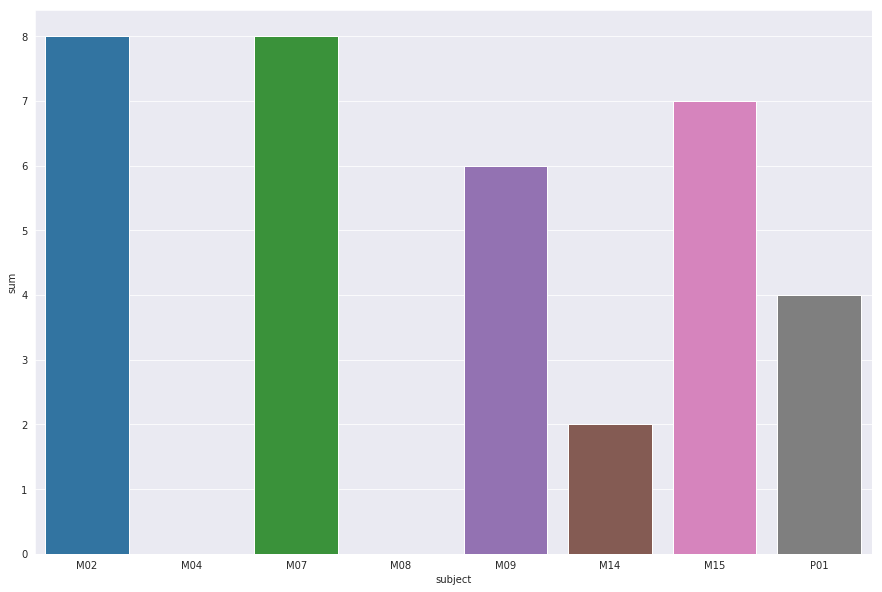

In [35]:
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(data=wilcoxon_results.groupby("subject").significant_bonferroni.agg(["sum"]).reset_index(),
            x="subject", y="sum", ax=ax)

In [26]:
wilcoxon_summary = wilcoxon_results.groupby(["model1", "model2"]).apply(lambda fs: fs.significant_bonferroni.sum())
wilcoxon_summary

model1     model2    
BERT       BERT-MNLI     4
           BERT-QQP      1
           BERT-SQuAD    4
           BERT-SST      6
BERT-MNLI  BERT-QQP      3
           BERT-SQuAD    0
           BERT-SST      4
BERT-QQP   BERT-SQuAD    3
BERT-SST   BERT-QQP      6
           BERT-SQuAD    4
dtype: int64

---------

# Aggregate graphs

In [27]:
f_mean = f[(f.metric == "ridge") & (f.stat == "mean")].sort_values(["target"])

## Decoding analysis

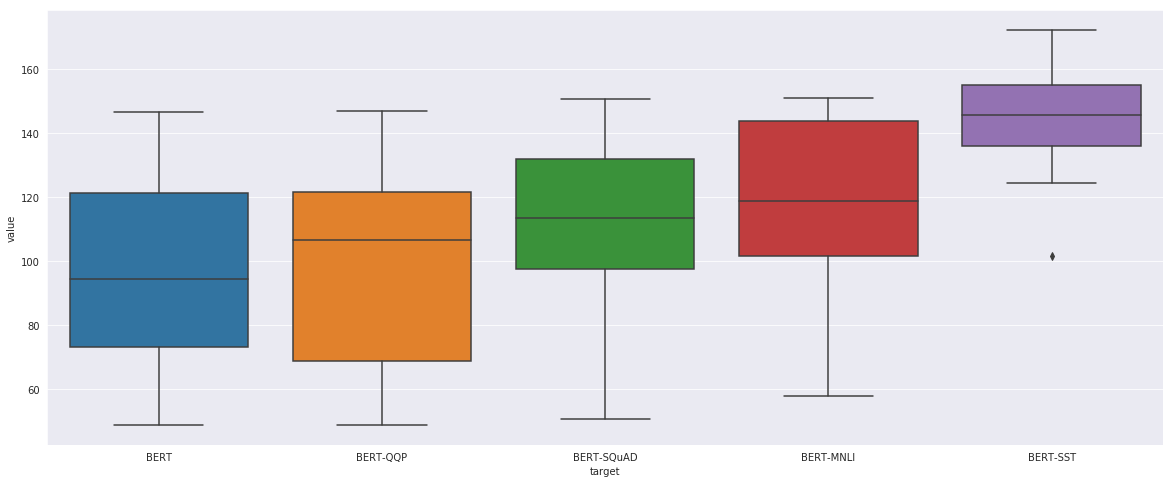

In [28]:
fig, ax = plt.subplots(figsize=(20, 8))
target_order = f_mean.groupby("target").value.mean().argsort()
sns.boxplot(x="target", y="value", data=f_mean,
            ax=ax, order=target_order.index[target_order])

In [29]:
f_mean.groupby("target").mean()

,value
target,
BERT,96.226190
BERT-MNLI,116.659061
BERT-QQP,98.552249
BERT-SQuAD,110.566799
BERT-SST,143.467593


[-0.4  0.6  1.6  2.6  3.6  0. ]


Text(0.87,-0.07,'* = p<0.01 for Bonferroni-corrected two-sided Wilcoxon test')

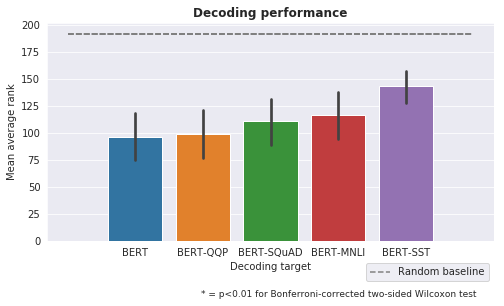

In [30]:
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(x="target", y="value", order=target_order.index[target_order], data=f_mean)
plt.xlabel("Decoding target")
plt.ylabel("Mean average rank")
plt.title("Decoding performance", weight="bold")

# Plot baseline
import matplotlib
bars = [child for child in ax.get_children() if isinstance(child, matplotlib.patches.Rectangle)]
baselines_start = np.array([plt.getp(item, "x") for item in bars])
baselines_end = baselines_start + np.array([plt.getp(item, "width") for item in bars])
print(baselines_start)
plt.hlines(np.repeat(384 / 2, len(target_order)), -1, len(target_order), colors="gray", linestyles="dashed", label="Random baseline")

# Plot legend
plt.legend(loc='upper right', bbox_to_anchor=(1, -0.08))

# Plot significant differences
xticks = list(zip(*plt.xticks()))
xticks = {label.get_text(): (pos, label) for pos, label in xticks}
# mean_results = f_mean.groupby("target").value.mean()
# for (m1, m2), row in wilcoxon_results.iterrows():
#     significant = row.significant_bonferroni
            
#     m1_pos, _ = xticks[m1]
#     m2_pos, _ = xticks[m2]
    
#     if significant:
#         y = max(mean_results[m1], mean_results[m2]) + 10
#         h = 5
#         col = 'k'
#         plt.plot([m1_pos + 0.1, m1_pos + 0.1, m2_pos - 0.1, m2_pos - 0.1], [y, y + h, y + h, y], lw=1.5, c=col)
#         plt.text((m1_pos+m2_pos)*.5, y + h, "*", ha='center', va='bottom', color=col)
        
plt.figtext(0.87, -0.07, "* = p<0.01 for Bonferroni-corrected two-sided Wilcoxon test", wrap=True, horizontalalignment='right', fontsize=9)

Text(0.5,1,'Decoding performance between subjects')

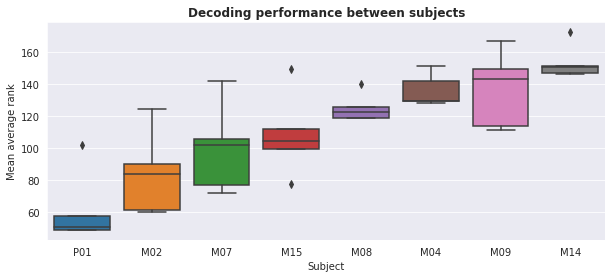

In [31]:
order = f_mean.groupby("subject").value.agg("mean").argsort()
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(x="subject", y="value", order=order.index[order], data=f_mean, ax=ax)
plt.xlabel("Subject")
plt.ylabel("Mean average rank")
plt.title("Decoding performance between subjects", weight="bold")

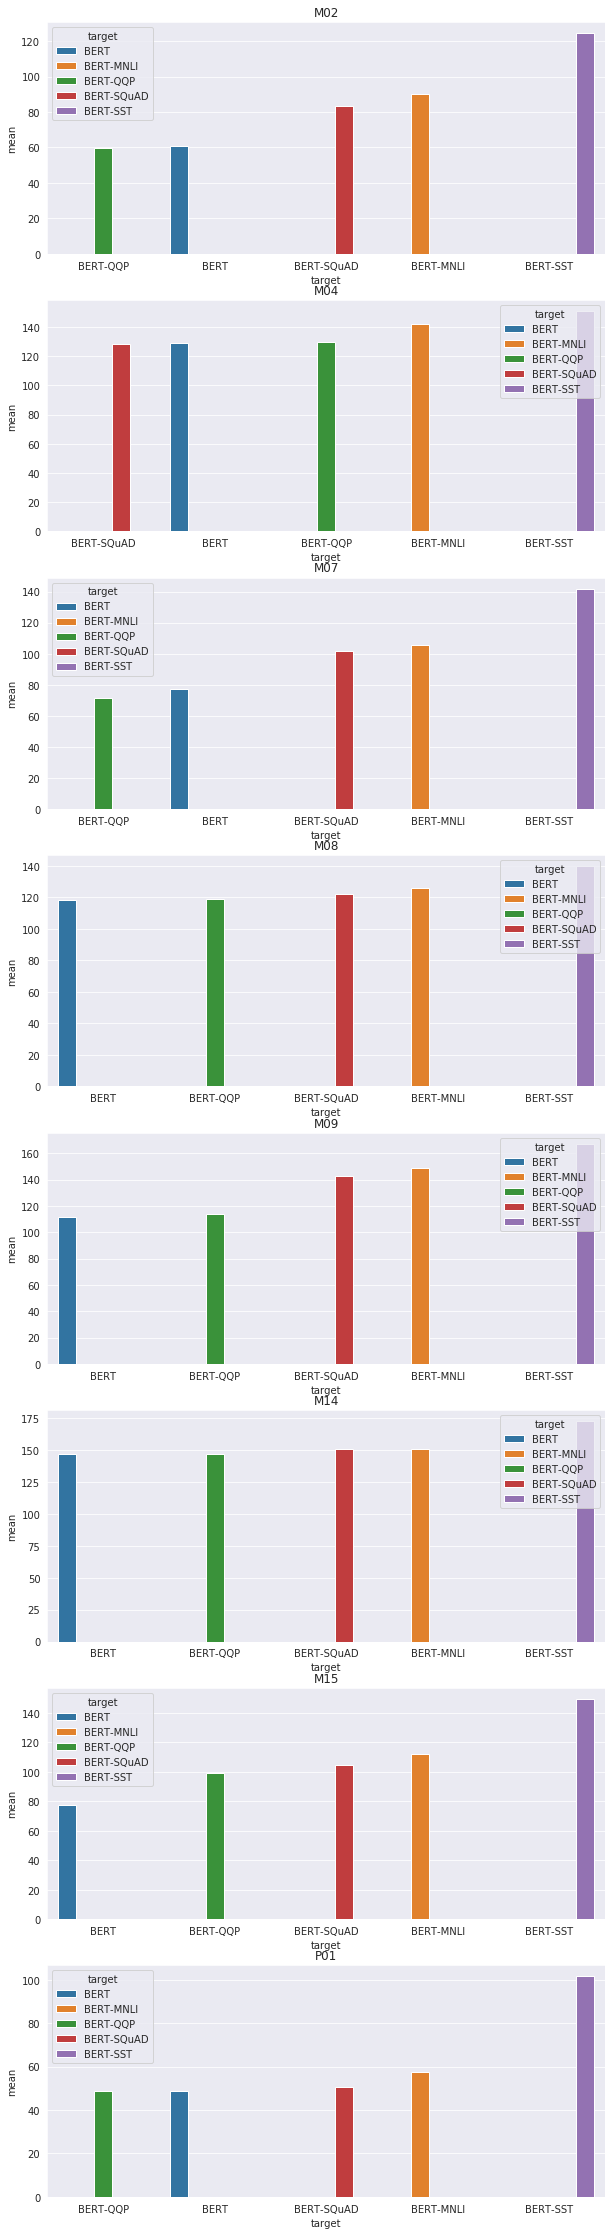

In [32]:
n_subjects = len(f_mean.subject.unique())
fig, axs = plt.subplots(n_subjects, 1, figsize=(10, 5 * n_subjects))
for ax, (subj, subj_data) in zip(axs, f[f.metric == "ridge"].groupby("subject")):
    subj_data = subj_data.set_index("stat").sort_index()
    subj_data = pd.pivot_table(subj_data, index=["target"], columns="stat")
    subj_data.columns = subj_data.columns.get_level_values(1)
    order = subj_data["mean"].argsort()
    sns.barplot(x="target", y="mean", data=subj_data.reset_index(), hue="target", order=order.index[order], ax=ax)
    ax.set_title(subj)
    
    # TODO plot yerr